# Extract data from captured network traffic

In [1]:
import pandas as pd
import re
import os
from tqdm import tqdm 

installed_apps = pd.read_csv('../data/installed_apps.csv')
app_ids = installed_apps['app_id'].astype(str).tolist()

# Define specific patterns for PII, PHI, and PII&PHI
specific_patterns = {
    "email": r"\b([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})\b",
    "phone number": r"\b(\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4})\b",
    "name": r"\b(?:[A-Z][a-z]+\s[A-Z][a-z]+|heather|jason|loewy|robert|williams)\b", #names used when registering for accounts
    "ip address": r"\b(?:\d{1,3}\.){3}\d{1,3}\b",
    "address": r"\b\d{1,5}\s[A-Za-z0-9\s,.'-]+(?:\s(?:Street|Ave|Road|Blvd|Drive|Ln|Lane|Ct|Court|Way|Parkway))?,\s[A-Za-z\s]+,\s[A-Za-z]{2}\s\d{5}\b",
    "religious belief": r"\b(?:religious|belief)\b",
    "race": r"\b(?:race|ethnicity)\b",
    "user content": r"\b(?:comments|photos|videos)\b",
    "birthdate": r"\b(?:\d{2}/\d{2}/\d{4}|dob|birthdate|date of birth)\b",
    "location": [
        r"\b(?:address|street address|city|county|precinct|zip code)\b",
        r"([+-]?\d{1,2}\.\d+)\s+([+-]?\d{1,3}\.\d+)",
        r"([NS])\s*(\d{1,2})°\s*(\d{1,2})'\s*(\d{1,2}\.\d+|[0-9]+)\s*[EW]\s*(\d{1,3})°\s*(\d{1,2})'\s*(\d{1,2}\.\d+|[0-9]+)"
    ],
    "geolocation": r"\b(?:latitude|longitude|GPS)\b",
    "medical record": r"\b(?:MRN|medical record number)\b",
    "health plan": r"\b(?:health plan|beneficiary number)\b",
    "diagnosis": r"\b(?:diagnosis|treatment|medical test|prescription)\b",
    "insurance": r"\b(?:insurance number|health insurance)\b",
    "psychotherapy": r"\b(?:psychotherapy notes)\b",
    "license number": r"\b(?:license number)\b",
    "ssn": r"\b(?:social security number|ssn)\b",
    "sexual orientation": r"\b(?:sexual orientation)\b",
    "political opinions": r"\b(?:political opinions)\b",
    
    # Device ID patterns (to be appended to PII)
    "device_id": {
        "aaid": r"\b(?:AAID)\b",
        "avdid": r"\b(?:Pixel_8a)\b",
        "aid": r"\b(?:AID)\b",
        "gsf id": r"\b(?:GSF ID)\b",
        "imei": r"\b(?:IMEI)\b",
        "imsi": r"\b(?:IMSI)\b",
        "hwid": r"\b(?:HWID)\b",
        "mac": r"\b(?:MAC)\b",
    },

    # Biometric patterns (to be appended to PHI)
    "biometric": {
        "fingerprints": r"\b(?:fingerprints)\b",
        "voice prints": r"\b(?:voice prints)\b",
        "biometric id": r"\b(?:biometric ID)\b",
    },

    # Health device patterns (to be appended to PHI)
    "health_device": {
        "heart rate": r"\b(?:heart rate)\b",
        "blood pressure": r"\b(?:blood pressure)\b",
        "glucose levels": r"\b(?:glucose levels)\b",
    },

    # Health app patterns (to be appended to PHI)
    "health_app": {
        "symptoms": r"\b(?:symptoms)\b",
        "medication tracking": r"\b(?:medication tracking)\b",
        "mental health logs": r"\b(?:mental health logs)\b",
    }
}

def check_specific_keywords(text, patterns):
    matches = {}
    for label, pattern in patterns.items():
        if isinstance(pattern, dict):  # Handle subcategories
            submatches = {sub_label for sub_label, sub_pattern in pattern.items() if re.search(sub_pattern, text, re.IGNORECASE)}
            if submatches:
                matches[label] = submatches
        elif isinstance(pattern, list):  # Handle multiple patterns
            if any(re.search(subpattern, text, re.IGNORECASE) for subpattern in pattern):
                matches[label] = {label}
        else:
            if re.search(pattern, text, re.IGNORECASE):
                matches[label] = {label}
    return matches

def contains_app_id(domain, app_ids):
    domain = domain.lower()
    if domain in ['www.google.com', 'google.com', 'localhost']:
        return False
    domain_parts = domain.split('.')[:-1]  # Exclude the TLD part (e.g., '.com')
    for part in domain_parts:
        if part not in ['www', 'google'] and any(part in app_id for app_id in app_ids):
            return True
    return False



traffic_data_dir = '../data/network_traffic'
domain_pattern = re.compile(r'https?://([a-zA-Z0-9.-]+)')
error_patterns = [
    r"server cannot be found", r"connection timed out", r"DNS error",
    r"host unreachable", r"connection refused", r"network unreachable", r"reset by peer", r"No Content", r"protocol error"
]

results = []

for file in tqdm(os.listdir(traffic_data_dir), desc="Processing logs"):
    if file.endswith('.log'):
        app_id = file.replace('.log', '')
        file_path = os.path.join(traffic_data_dir, file)

        try:
            with open(file_path, 'r', encoding='utf-8', errors='replace') as log_file:
                network_traffic = log_file.readlines()
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

        if not network_traffic:
            continue  # Skip empty files

        third_party_domains = set()
        pii = set()
        phi = set()
        pii_phi = set()
        connectivity_issues = set()

        for line in network_traffic:
            match = domain_pattern.search(line)
            if match:
                domain = match.group(1)
                if not contains_app_id(domain, app_ids):
                    third_party_domains.add(domain)

                specific_matches = check_specific_keywords(line, specific_patterns)

                # Append device_id details to PII
                if "device_id" in specific_matches:
                    pii.update(specific_matches["device_id"])

                # Append biometric, health_device, and health_app details to PHI
                for category in ["biometric", "health_device", "health_app"]:
                    if category in specific_matches:
                        phi.update(specific_matches[category])

                # Regular PII and PHI processing
                pii.update([label for label in specific_matches if label in ["user content", "religious belief", "race"]])
                phi.update([label for label in specific_matches if label in ["medical record", "health plan", "diagnosis", "insurance", "psychotherapy"]])
                pii_phi.update([label for label in specific_matches if label in ["name", "address", "birthdate", "location", "geolocation",
                                                                                 "ip address", "email", "phone", "license number", "ssn",
                                                                                 "sexual orientation", "political opinions"]])

            for pattern in error_patterns:
                if re.search(pattern, line, re.IGNORECASE):
                    connectivity_issues.add(pattern)

        pii_phi.difference_update(pii.union(phi))

        domains = ','.join(domain for domain in third_party_domains if domain)
        results.append({
            'app_id': app_id,
            'domains': domains,
            'PII': ','.join(sorted(pii)) if pii else None,
            'PHI': ','.join(sorted(phi)) if phi else None,
            'PII&PHI': ','.join(sorted(pii_phi)) if pii_phi else None,
            'Connectivity Issues': ','.join(connectivity_issues) if connectivity_issues else None
        })


unique_domains = set(domain.strip() for result in results if result['domains'] for domain in result['domains'].split(',') if domain.strip())
print('Unique third-party domains:', len(unique_domains))

traffic_results = pd.DataFrame(results)
traffic_results.to_csv('../data/traffic_results.csv', index=False)
print("Results saved to traffic_results.csv")


Processing logs: 100%|████████████████████████| 762/762 [06:25<00:00,  1.97it/s]

Unique third-party domains: 818
Results saved to traffic_results.csv


# Analyzing Thrid Party Domains

In [2]:
import pandas as pd

domain_counts = {domain: 0 for domain in unique_domains}

for _, row in traffic_results.iterrows():
    domains_list = row['domains']
    if isinstance(domains_list, str):
        domains_list = domains_list.split(',')
    elif not isinstance(domains_list, list):
        domains_list = []
    for domain in unique_domains:
        domain_counts[domain] += domains_list.count(domain)

domain_counts_df = pd.DataFrame(list(domain_counts.items()), columns=['domains', 'count'])
domain_counts_df = domain_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)
domain_counts_df.to_csv('../data/unique_domains.csv', index=False)

In [3]:
unique_domains = pd.read_csv('../data/categorized_unique_domains.csv')
print(unique_domains['category'].value_counts()[:10])

category
Photography        48
Advertising        48
CDN                33
Cloud Storage      29
E-commerce         23
Web Development    18
App Analytics      17
Food Blog          17
Security           16
App Hosting        15
Name: count, dtype: int64


In [1]:
import pandas as pd
import os

traffic_data_dir = '../data/network_traffic'
traffic_results = pd.read_csv('../data/traffic_results.csv')

crashed_apps = traffic_results[
    traffic_results['PII'].isnull() & 
    traffic_results['PHI'].isnull() & 
    traffic_results['PII&PHI'].isnull() &
    traffic_results['Connectivity Issues'].notnull()
]
print("Apps crashed during launch:", len(crashed_apps))
print(len(os.listdir(traffic_data_dir)) - len(crashed_apps))


Apps crashed during launch: 42
720


# Analyzing PII and PHI

In [2]:
import pandas as pd

traffic_results = pd.read_csv('../data/traffic_results.csv')

pii_apps = traffic_results[traffic_results['PII'].notnull()]
phi_apps = traffic_results[traffic_results['PHI'].notnull()]
pii_phi_apps = traffic_results[traffic_results['PII&PHI'].notnull()]

print('Number of apps collecting or sharing PII:', len(pii_apps))
print('Number of apps collecting or sharing PHI:', len(phi_apps))
print('Number of apps collecting or sharing PII&PHI:', len(pii_phi_apps))

Number of apps collecting or sharing PII: 120
Number of apps collecting or sharing PHI: 56
Number of apps collecting or sharing PII&PHI: 517


In [3]:
import pandas as pd

mhealth_apps = pd.read_csv('../data/updated_mhealth_apps.csv')
copy_traffic_results = traffic_results.copy()

# Map categories based on app_id
copy_traffic_results['categories'] = copy_traffic_results['app_id'].map(
    mhealth_apps.set_index('app_id')['categories']
)
category_counts_raw = copy_traffic_results.groupby('categories').size().reset_index(name='total_count')
category_counts_raw = category_counts_raw.sort_values(by='total_count', ascending=False).reset_index(drop=True)

category_counts_raw


,categories,total_count
0,Health & Fitness,470
1,Medical,153
2,Parenting,35
3,Education,25
4,Lifestyle,18
5,Productivity,6
6,Shopping,6
7,Food & Drink,5
8,Tools,4
9,Sports,3



Comparison of top categories with 'Others':
                  Original_%  Traffic_%
Health & Fitness   62.763466  63.772049
Medical            21.077283  20.759837
Parenting           5.035129   4.748982
Education           2.927400   3.392130
Lifestyle           2.810304   2.442334
Others              5.386417   4.884668


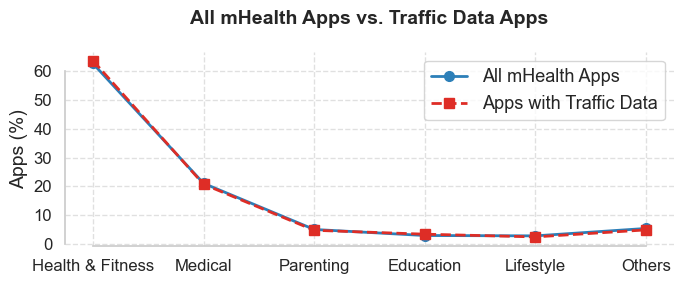

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Get app_ids from traffic_results
app_ids_traffic = traffic_results['app_id']

# Count categories for mhealth_apps (full dataset)
original_counts = mhealth_apps['categories'].value_counts()

# Count categories for apps present in traffic_results
traffic_counts = mhealth_apps[mhealth_apps['app_id'].isin(app_ids_traffic)]['categories'].value_counts()

# Normalize counts to percentages
original_percent = original_counts / original_counts.sum() * 100
traffic_percent = traffic_counts / traffic_counts.sum() * 100

# Combine into DataFrame
comparison_percent = pd.DataFrame({
    'Original_%': original_percent,
    'Traffic_%': traffic_percent
}).fillna(0)

# Sort by Original_% descending
comparison_percent = comparison_percent.sort_values(by='Original_%', ascending=False)

# Group categories below top 5 into 'Others'
top_categories = comparison_percent.head(5)
other_categories = comparison_percent.iloc[5:].sum().to_frame().T
other_categories.index = ['Others']

# Combine top categories with 'Others'
grouped_comparison = pd.concat([top_categories, other_categories])

print("\nComparison of top categories with 'Others':")
print(grouped_comparison)

# Elegant line chart
plt.figure(figsize=(7, 3))
plt.plot(grouped_comparison.index, grouped_comparison['Original_%'], 
         marker='o', linestyle='-', linewidth=2, markersize=7, 
         label='All mHealth Apps', color='#2c7fb8')
plt.plot(grouped_comparison.index, grouped_comparison['Traffic_%'], 
         marker='s', linestyle='--', linewidth=2, markersize=7, 
         label='Apps with Traffic Data', color='#de2d26')

plt.title('All mHealth Apps vs. Traffic Data Apps',
          fontsize=14, weight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Apps (%)', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=True, fontsize=13, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('../figures/original_vs_missing.png', bbox_inches='tight')

plt.show()


In [5]:
category_counts = copy_traffic_results.groupby('categories').agg(
    apps_with_pii=('PII', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2)),
    apps_with_phi=('PHI', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2)),
    apps_with_pii_phi=('PII&PHI', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2))
).reset_index()

category_counts = category_counts.merge(category_counts_raw, on='categories')
category_counts = category_counts.sort_values(by='total_count', ascending=False).reset_index(drop=True)

top_5_categories = category_counts['categories'].head(5)

# Group categories that are not in the top 5 into 'Others'
copy_traffic_results['categories'] = copy_traffic_results['categories'].apply(
    lambda x: x if x in top_5_categories.values else 'Others'
)

# Recalculate the aggregations with the new 'Others' category
category_counts = copy_traffic_results.groupby('categories').agg(
    apps_with_pii=('PII', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2)),
    apps_with_phi=('PHI', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2)),
    apps_with_pii_phi=('PII&PHI', lambda x: round(((x.notna() & (x != '')).sum() / len(x)) * 100, 2)),
    total_count=('categories', 'size')  # Recalculate total count
).reset_index()

category_counts = category_counts.sort_values(by='total_count', ascending=False).reset_index(drop=True)
category_counts


,categories,apps_with_pii,apps_with_phi,apps_with_pii_phi,total_count
0,Health & Fitness,17.66,7.66,76.60,470
1,Medical,14.38,7.19,56.21,153
2,Others,17.07,7.32,70.73,41
3,Parenting,2.86,2.86,28.57,35
4,Education,8.00,8.00,80.00,25
5,Lifestyle,27.78,16.67,66.67,18


In [6]:
def extract_unique_item(dataframe):
    unique_items = set()
    for lists in dataframe.dropna():
        items = str(lists).split(",")
        unique_items.update(item.strip() for item in items)
    return unique_items

unique_pii = extract_unique_item(copy_traffic_results['PII'])
unique_pii

{'aaid', 'aid', 'imsi', 'mac', 'race', 'religious belief', 'user content'}

In [7]:
from collections import Counter
import pandas as pd

def count_occurrences(dataframe, column_name, unique_values):
    value_counts = {value: 0 for value in unique_values}
    for _, row in dataframe.iterrows():
        value_list = row[column_name]
        if isinstance(value_list, str):
            value_list = value_list.split(',')
        elif not isinstance(value_list, list):
            value_list = []
        value_counter = Counter(value_list)
        for value in value_counts.keys():
            value_counts[value] += value_counter.get(value, 0)
    counts_df = pd.DataFrame(list(value_counts.items()), columns=[column_name, 'count'])
    counts_df = counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return counts_df


In [8]:
pii_counts_df = count_occurrences(copy_traffic_results, 'PII', unique_pii)
pii_counts_df

,PII,count
0,user content,56
1,aaid,47
2,aid,34
3,race,22
4,mac,17
5,religious belief,14
6,imsi,1


In [9]:
unique_phi = extract_unique_item(copy_traffic_results['PHI'])
unique_phi

{'blood pressure',
 'diagnosis',
 'fingerprints',
 'glucose levels',
 'health plan',
 'heart rate',
 'insurance',
 'medical record',
 'symptoms'}

In [10]:
phi_counts_df = count_occurrences(copy_traffic_results, 'PHI', unique_phi)
phi_counts_df

,PHI,count
0,diagnosis,33
1,blood pressure,25
2,symptoms,22
3,heart rate,13
4,insurance,5
5,health plan,2
6,medical record,2
7,glucose levels,1
8,fingerprints,1


In [11]:
unique_pii_phi = extract_unique_item(copy_traffic_results['PII&PHI'])
unique_pii_phi

{'birthdate',
 'email',
 'geolocation',
 'ip address',
 'location',
 'name',
 'sexual orientation',
 'ssn'}

In [12]:
pii_phi_counts_df = count_occurrences(copy_traffic_results, 'PII&PHI', unique_pii_phi)
pii_phi_counts_df

,PII&PHI,count
0,name,510
1,ip address,510
2,location,478
3,email,194
4,birthdate,53
5,geolocation,19
6,ssn,9
7,sexual orientation,1


# Merge results from network traffic and data safety

In [13]:
merged_df = pd.merge(mhealth_apps, traffic_results, on='app_id', how='left')
merged_df.to_csv('../data/merged_df.csv', index=False)